In [1]:
from PIL import Image
from matplotlib.pyplot import imshow
from torchvision import models, transforms
from torch.autograd import Variable
from torch.nn import functional as F
from torch import topk
import torch
import numpy as np
import skimage.transform

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from collections import Counter
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
from pylab import *
from copy import deepcopy
from PIL import Image
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn as sns
import cv2
import numpy as np
from pathlib import Path
from PIL import Image, ImageStat

plt.ion()  

device = torch.cuda.is_available()
if device:
    print("Using CUDA")
cuda = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Using CUDA


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = '/content/drive/My Drive/Thesis/Elbow'
TEST = 'test'
TRAIN = 'train'
VAL = 'validate'

data_transforms = {
    TRAIN: transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, VAL, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=4
    )
    for x in [TRAIN, VAL, TEST]
}
display_transform = transforms.Compose([
   transforms.Resize((224,224))])

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL, TEST]}

for x in [TRAIN, VAL, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 4761 images under train
Loaded 635 images under validate
Loaded 173 images under test
Classes: 
['0', '1']


In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = ((output.cpu()).data).numpy()
    def remove(self): self.hook.remove()


def is_grayscale(image):

    trans = transforms.ToTensor()
    if trans(image).shape[0] == 1:
        return True
    else:
        return False

def load_input_image(img_path):
    image = Image.open(Path(img_path))
    image_transform= transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
        ])
    if is_grayscale(image) == True:
      #print(" is a GreyScale Image")
      image = image.convert('RGB')
    image = image_transform(image)
    print(image.shape)
    return image

def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]


torch.Size([3, 224, 224])


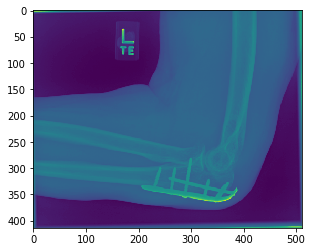

In [11]:
image_path="/content/drive/My Drive/Thesis/Elbow/train/1/2034.png"
image = Image.open("/content/drive/My Drive/Thesis/Elbow/train/1/2034.png")
imshow(image)
image_tensor= load_input_image(image_path)

In [0]:
checkpoint=torch.load('/content/drive/My Drive/Thesis/Elbow/resnet50_Elbow_1305.pth',map_location='cpu')

In [13]:
resnet_model = models.resnet50()
resnet_model.fc = nn.Linear(in_features=resnet_model.fc.in_features, out_features=2)
resnet_model.load_state_dict(checkpoint,strict=False)
print("Model Loaded")


Model Loaded


In [14]:
final_layer = resnet_model._modules.get('layer4')
activated_features = SaveFeatures(final_layer)
image= load_input_image(image_path)
predict_val = Variable((image.unsqueeze(0)), requires_grad=True)
prediction = resnet_model(predict_val)
pred_prob = F.softmax(prediction).data.squeeze()
activated_features.remove()
top=topk(pred_prob,1)
print("Probability predicted",top)


torch.Size([3, 224, 224])
Probability predicted torch.return_types.topk(
values=tensor([0.5874]),
indices=tensor([0]))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [0]:
weight_softmax_params = list(resnet_model._modules.get('fc').parameters())
weight_softmax = np.squeeze(weight_softmax_params[0].data.numpy())
class_idx = topk(pred_prob,1)[1].int()


In [16]:
print(activated_features.features.shape)
print("weight_softmax_params[0]",weight_softmax_params[0].shape)
print("here",weight_softmax[0].dtype)

(1, 2048, 7, 7)
weight_softmax_params[0] torch.Size([2, 2048])
here float32


In [0]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx )

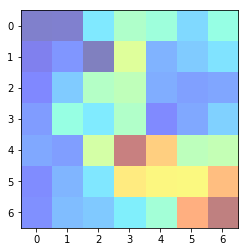

In [18]:
imshow(overlay[0], alpha=0.5, cmap='jet')

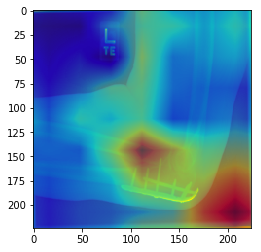

In [21]:
#image = Image.open("/content/drive/My Drive/Thesis/Elbow/train/1/2034.png")
imshow(display_transform(image))
imshow(skimage.transform.resize(overlay[0], image_tensor.shape[1:3]), alpha=0.5, cmap='jet');